# 📘 Manajemen Jadwal Kuliah
Notebook ini menyimpan jadwal kuliah beberapa kelas dan menampilkan kelas dengan jadwal kuliah paling efisien (jumlah hari kuliah paling sedikit).

In [5]:
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Data jadwal dari tabel
schedule_data = {
    'Subject': [
        'Research Methodology', 'Research Methodology', 'Professional English', 
        'Data Science Project', 'Data Analytic and Visualization Project', 'Big Data Project',
        'Professional English', 'Data Science Project', 'Data Analytic and Visualization Project', 
        'Big Data Project'
    ],
    'Cr': [2, 2, 0, 3, 3, 3, 0, 3, 3, 3],
    'Elective_Course': ['YES', 'YES', 'NO', 'YES', 'YES', 'YES', 'NO', 'YES', 'YES', 'YES'],
    'Room': [
        'Online Class / Online Class', 'Online Class / Online Class', 'B403 / LabA215',
        'LabA216 / LabA216', 'LabA216 / LabA216', 'LabA216 / LabA216',
        'B307 / B308', 'LabA216 / LabA216', 'LabA216 / LabA216', 'LabA216 / LabA216'
    ],
    'Sched_Time_1': [
        'Mon, 07:00-08:30', 'Mon, 09:30-11:00', 'Mon, 14:30-16:45',
        'Mon, 07:00-09:15', 'Wed, 07:00-09:15', 'Wed, 09:30-11:45',
        'Tue, 14:30-16:45', 'Mon, 07:00-09:15', 'Wed, 07:00-09:15', 'Wed, 09:30-11:45'
    ],
    'Sched_Time_2': [
        'Wed, 07:00-08:30', 'Thu, 07:00-08:30', 'Thu, 14:30-16:45',
        'Tue, 07:00-09:15', 'Thu, 07:00-09:15', 'Fri, 07:00-09:15',
        'Thu, 14:30-16:45', 'Tue, 07:00-09:15', 'Thu, 07:00-09:15', 'Fri, 07:00-09:15'
    ]
}

# Membuat DataFrame dengan penambahan kolom Class_ID
df = pd.DataFrame(schedule_data)



In [6]:
# Menambahkan kolom Class_ID untuk membedakan kelas
class_counter = {}
df['Class_ID'] = ''
for idx, row in df.iterrows():
    subject = row['Subject']
    if subject not in class_counter:
        class_counter[subject] = 0
    class_counter[subject] += 1
    df.at[idx, 'Class_ID'] = f"Kelas {class_counter[subject]}"

print("=== DATA JADWAL KULIAH (DENGAN IDENTIFIKASI KELAS) ===")
print(df[['Subject', 'Class_ID', 'Cr', 'Elective_Course', 'Room', 'Sched_Time_1', 'Sched_Time_2']].to_string(index=False))
print("\n")



=== DATA JADWAL KULIAH (DENGAN IDENTIFIKASI KELAS) ===
                                Subject Class_ID  Cr Elective_Course                        Room     Sched_Time_1     Sched_Time_2
                   Research Methodology  Kelas 1   2             YES Online Class / Online Class Mon, 07:00-08:30 Wed, 07:00-08:30
                   Research Methodology  Kelas 2   2             YES Online Class / Online Class Mon, 09:30-11:00 Thu, 07:00-08:30
                   Professional English  Kelas 1   0              NO              B403 / LabA215 Mon, 14:30-16:45 Thu, 14:30-16:45
                   Data Science Project  Kelas 1   3             YES           LabA216 / LabA216 Mon, 07:00-09:15 Tue, 07:00-09:15
Data Analytic and Visualization Project  Kelas 1   3             YES           LabA216 / LabA216 Wed, 07:00-09:15 Thu, 07:00-09:15
                       Big Data Project  Kelas 1   3             YES           LabA216 / LabA216 Wed, 09:30-11:45 Fri, 07:00-09:15
                   Professio

In [7]:
# Fungsi untuk mengkonversi waktu ke format yang bisa dibandingkan
def parse_time(time_str):
    """Parse waktu dari format 'Day, HH:MM-HH:MM' menjadi tuple (day, start_hour, start_min, end_hour, end_min)"""
    day_map = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
    
    parts = time_str.split(', ')
    day = day_map[parts[0]]
    time_range = parts[1].split('-')
    
    start_time = time_range[0].split(':')
    end_time = time_range[1].split(':')
    
    start_hour, start_min = int(start_time[0]), int(start_time[1])
    end_hour, end_min = int(end_time[0]), int(end_time[1])
    
    return (day, start_hour, start_min, end_hour, end_min)

# Fungsi untuk mengecek apakah dua waktu bertabrakan
def is_time_conflict(time1, time2):
    """Mengecek apakah dua jadwal bertabrakan"""
    day1, start_h1, start_m1, end_h1, end_m1 = parse_time(time1)
    day2, start_h2, start_m2, end_h2, end_m2 = parse_time(time2)
    
    # Jika hari berbeda, tidak bertabrakan
    if day1 != day2:
        return False
    
    # Konversi ke menit untuk perbandingan yang lebih mudah
    start1 = start_h1 * 60 + start_m1
    end1 = end_h1 * 60 + end_m1
    start2 = start_h2 * 60 + start_m2
    end2 = end_h2 * 60 + end_m2
    
    # Cek apakah ada overlap
    return not (end1 <= start2 or end2 <= start1)

# Mengidentifikasi semua opsi kelas untuk setiap mata kuliah
subjects_with_classes = {}
for idx, row in df.iterrows():
    subject = row['Subject']
    class_id = row['Class_ID']
    
    key = f"{subject} - {class_id}"
    subjects_with_classes[key] = {
        'index': idx,
        'subject': subject,
        'class_id': class_id,
        'schedule_1': row['Sched_Time_1'],
        'schedule_2': row['Sched_Time_2'],
        'room': row['Room'],
        'credits': row['Cr'],
        'elective': row['Elective_Course']
    }

print("=== SEMUA OPSI KELAS DAN JADWALNYA ===")
current_subject = None
for key, info in subjects_with_classes.items():
    if current_subject != info['subject']:
        current_subject = info['subject']
        print(f"\n{current_subject}:")
    
    print(f"  {info['class_id']}:")
    print(f"    Opsi Jadwal 1: {info['schedule_1']}")
    print(f"    Opsi Jadwal 2: {info['schedule_2']}")
    print(f"    Ruangan: {info['room']}")



=== SEMUA OPSI KELAS DAN JADWALNYA ===

Research Methodology:
  Kelas 1:
    Opsi Jadwal 1: Mon, 07:00-08:30
    Opsi Jadwal 2: Wed, 07:00-08:30
    Ruangan: Online Class / Online Class
  Kelas 2:
    Opsi Jadwal 1: Mon, 09:30-11:00
    Opsi Jadwal 2: Thu, 07:00-08:30
    Ruangan: Online Class / Online Class

Professional English:
  Kelas 1:
    Opsi Jadwal 1: Mon, 14:30-16:45
    Opsi Jadwal 2: Thu, 14:30-16:45
    Ruangan: B403 / LabA215

Data Science Project:
  Kelas 1:
    Opsi Jadwal 1: Mon, 07:00-09:15
    Opsi Jadwal 2: Tue, 07:00-09:15
    Ruangan: LabA216 / LabA216

Data Analytic and Visualization Project:
  Kelas 1:
    Opsi Jadwal 1: Wed, 07:00-09:15
    Opsi Jadwal 2: Thu, 07:00-09:15
    Ruangan: LabA216 / LabA216

Big Data Project:
  Kelas 1:
    Opsi Jadwal 1: Wed, 09:30-11:45
    Opsi Jadwal 2: Fri, 07:00-09:15
    Ruangan: LabA216 / LabA216

Professional English:
  Kelas 2:
    Opsi Jadwal 1: Tue, 14:30-16:45
    Opsi Jadwal 2: Thu, 14:30-16:45
    Ruangan: B307 / B308

In [8]:
# Membuat fungsi untuk generate kombinasi
def generate_all_combinations():
    """Generate semua kemungkinan kombinasi kelas dan jadwal"""
    combinations = []
    
    # Identifikasi mata kuliah unik dan kelas-kelasnya
    unique_subjects = {}
    for key, info in subjects_with_classes.items():
        subject = info['subject']
        if subject not in unique_subjects:
            unique_subjects[subject] = []
        unique_subjects[subject].append(key)
    
    print(f"\n=== MATA KULIAH DAN PILIHAN KELASNYA ===")
    for subject, classes in unique_subjects.items():
        print(f"{subject}: {len(classes)} kelas tersedia")
    
    # Generate semua kombinasi
    subject_names = list(unique_subjects.keys())
    class_choices = [unique_subjects[subject] for subject in subject_names]
    
    total_combinations = 1
    for choices in class_choices:
        total_combinations *= len(choices) * 2  # 2 untuk setiap pilihan jadwal (1 atau 2)
    
    print(f"\nTotal kemungkinan kombinasi: {total_combinations}")
    
    # Generate kombinasi kelas
    for class_combo in product(*class_choices):
        # Untuk setiap kombinasi kelas, coba semua kemungkinan jadwal (1 atau 2)
        for schedule_combo in product([1, 2], repeat=len(class_combo)):
            schedule_dict = {}
            schedule_times = []
            valid_combo = True
            
            for i, class_key in enumerate(class_combo):
                chosen_schedule = schedule_combo[i]
                class_info = subjects_with_classes[class_key]
                
                if chosen_schedule == 1:
                    time_slot = class_info['schedule_1']
                    room = class_info['room'].split(' / ')[0]
                else:
                    time_slot = class_info['schedule_2']
                    room = class_info['room'].split(' / ')[1]
                
                # Cek konflik dengan jadwal yang sudah ada
                for existing_time in schedule_times:
                    if is_time_conflict(time_slot, existing_time):
                        valid_combo = False
                        break
                
                if not valid_combo:
                    break
                
                schedule_dict[class_key] = {
                    'subject': class_info['subject'],
                    'class_id': class_info['class_id'],
                    'chosen_schedule': chosen_schedule,
                    'time': time_slot,
                    'room': room,
                    'credits': class_info['credits']
                }
                schedule_times.append(time_slot)
            
            if valid_combo:
                combinations.append(schedule_dict)
    
    return combinations

# Generate semua kombinasi yang valid
print("\n=== MENCARI SEMUA KOMBINASI JADWAL YANG VALID ===")
valid_combinations = generate_all_combinations()

print(f"\nDitemukan {len(valid_combinations)} kombinasi jadwal yang valid!\n")

# Menampilkan semua kombinasi yang valid dengan detail kelas
for i, combo in enumerate(valid_combinations):
    print(f"=== KEMUNGKINAN JADWAL {i+1} ===")
    
    # Urutkan berdasarkan hari dan waktu
    schedule_items = []
    total_credits = 0
    
    for class_key, details in combo.items():
        day, start_h, start_m, end_h, end_m = parse_time(details['time'])
        schedule_items.append((day, start_h, start_m, class_key, details))
        total_credits += details['credits']
    
    schedule_items.sort(key=lambda x: (x[0], x[1], x[2]))
    
    day_names = {1: 'Senin', 2: 'Selasa', 3: 'Rabu', 4: 'Kamis', 5: 'Jumat', 6: 'Sabtu', 7: 'Minggu'}
    
    current_day = None
    for day_num, start_h, start_m, class_key, details in schedule_items:
        if current_day != day_num:
            current_day = day_num
            print(f"\n{day_names[day_num]}:")
        
        time_display = details['time'].split(', ')[1]
        schedule_choice = f"Jadwal {details['chosen_schedule']}"
        print(f"  {time_display:12} | {details['subject']:35} | {details['class_id']:8} | {details['room']:15} | ({schedule_choice})")
    
    print(f"\nTotal SKS: {total_credits}")
    print("="*80)




=== MENCARI SEMUA KOMBINASI JADWAL YANG VALID ===

=== MATA KULIAH DAN PILIHAN KELASNYA ===
Research Methodology: 2 kelas tersedia
Professional English: 2 kelas tersedia
Data Science Project: 2 kelas tersedia
Data Analytic and Visualization Project: 2 kelas tersedia
Big Data Project: 2 kelas tersedia

Total kemungkinan kombinasi: 1024

Ditemukan 640 kombinasi jadwal yang valid!

=== KEMUNGKINAN JADWAL 1 ===

Senin:
  07:00-08:30  | Research Methodology                | Kelas 1  | Online Class    | (Jadwal 1)
  14:30-16:45  | Professional English                | Kelas 1  | B403            | (Jadwal 1)

Selasa:
  07:00-09:15  | Data Science Project                | Kelas 1  | LabA216         | (Jadwal 2)

Rabu:
  07:00-09:15  | Data Analytic and Visualization Project | Kelas 1  | LabA216         | (Jadwal 1)
  09:30-11:45  | Big Data Project                    | Kelas 1  | LabA216         | (Jadwal 1)

Total SKS: 11
=== KEMUNGKINAN JADWAL 2 ===

Senin:
  07:00-08:30  | Research Methodo


=== MEMBUAT VISUALISASI ===


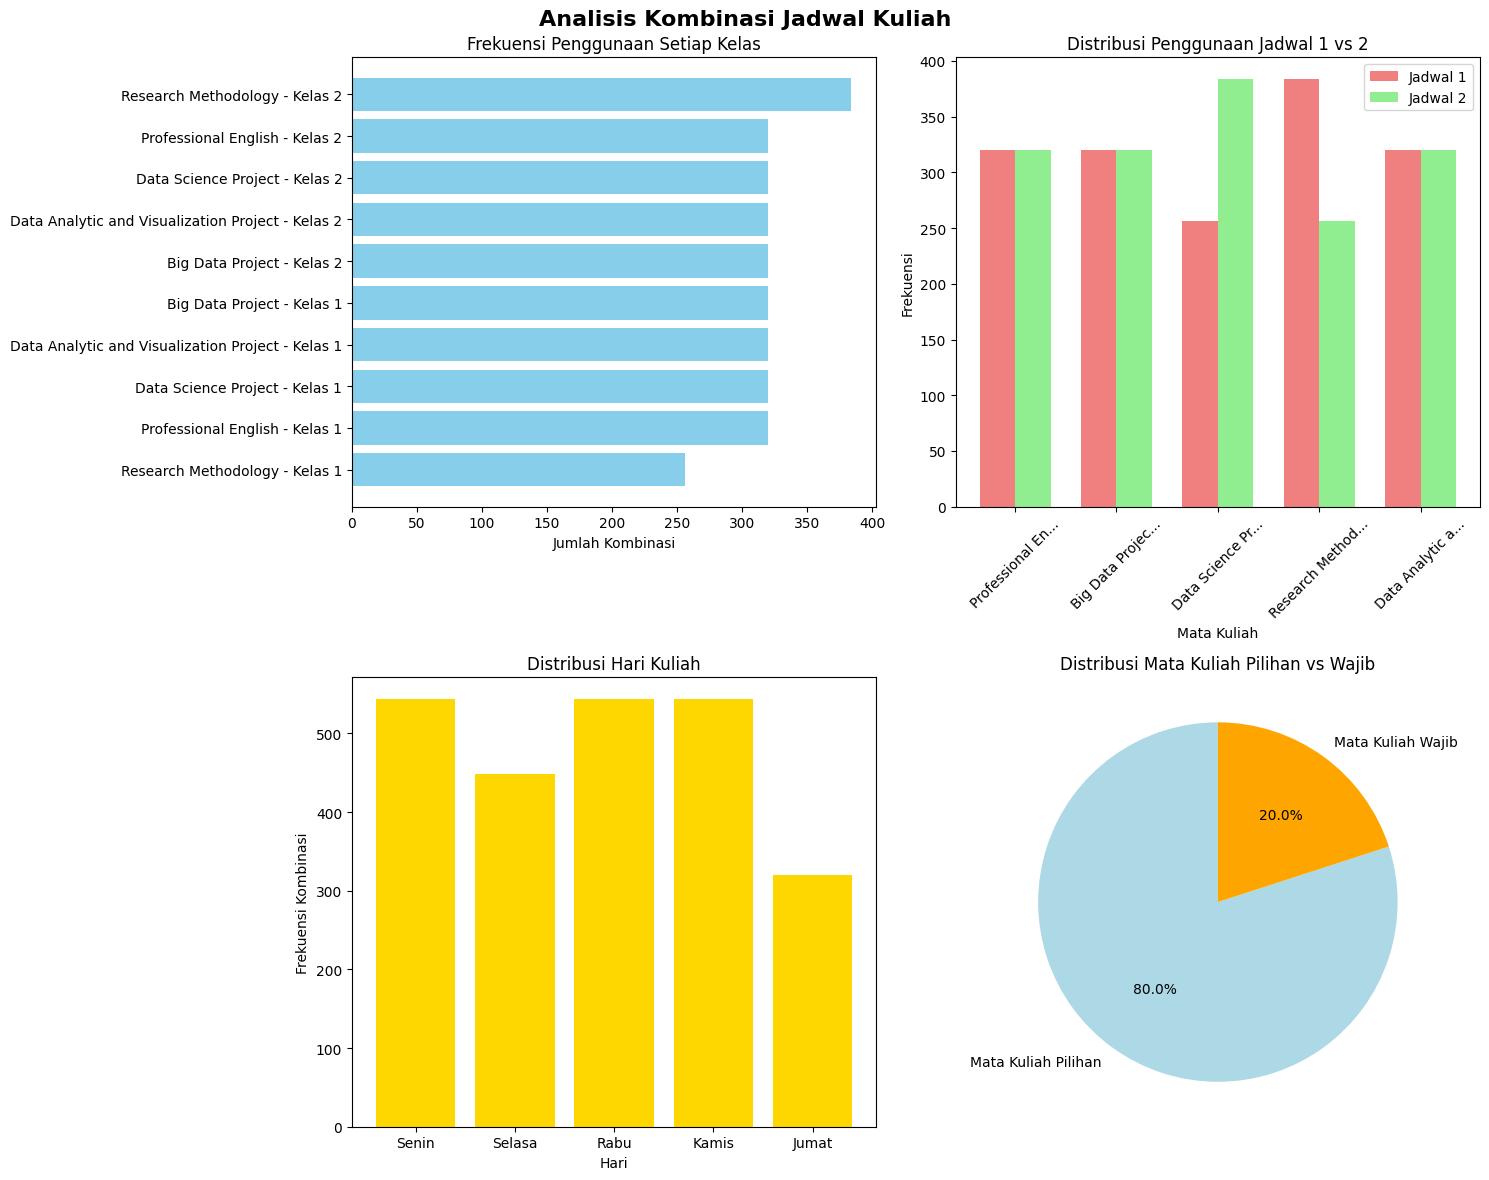

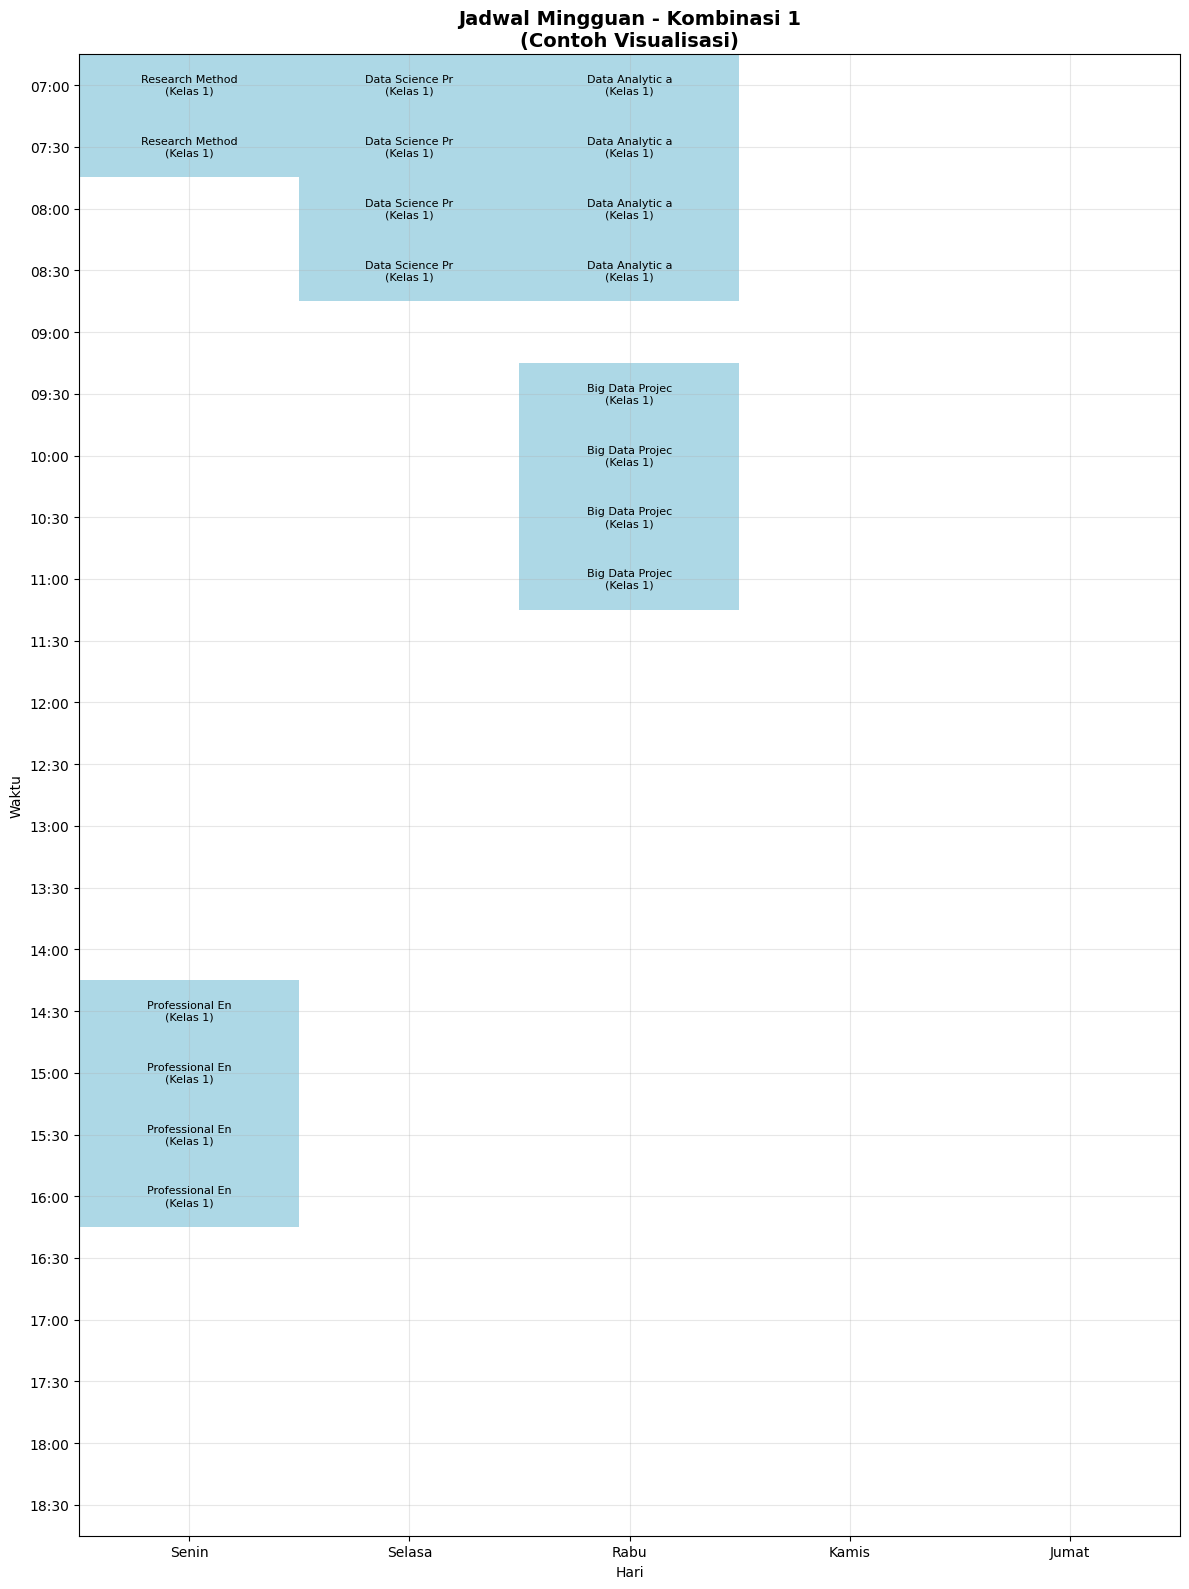


=== RINGKASAN LENGKAP ===
Total mata kuliah unik: 5
Total pilihan kelas: 10
Kombinasi jadwal yang valid (tanpa bentrok): 640

=== REKOMENDASI ===
Berikut adalah beberapa kombinasi jadwal terbaik yang bisa Anda pilih:

Rekomendasi 1:
  • Research Methodology - Kelas 1: Mon, 07:00-08:30 (Jadwal 1)
  • Professional English - Kelas 1: Mon, 14:30-16:45 (Jadwal 1)
  • Data Science Project - Kelas 1: Tue, 07:00-09:15 (Jadwal 2)
  • Data Analytic and Visualization Project - Kelas 1: Wed, 07:00-09:15 (Jadwal 1)
  • Big Data Project - Kelas 1: Wed, 09:30-11:45 (Jadwal 1)

Rekomendasi 2:
  • Research Methodology - Kelas 1: Mon, 07:00-08:30 (Jadwal 1)
  • Professional English - Kelas 1: Mon, 14:30-16:45 (Jadwal 1)
  • Data Science Project - Kelas 1: Tue, 07:00-09:15 (Jadwal 2)
  • Data Analytic and Visualization Project - Kelas 1: Wed, 07:00-09:15 (Jadwal 1)
  • Big Data Project - Kelas 1: Fri, 07:00-09:15 (Jadwal 2)

Rekomendasi 3:
  • Research Methodology - Kelas 1: Mon, 07:00-08:30 (Jadwal 1)


In [9]:
# Membuat visualisasi
def create_visualizations(valid_combinations):
    """Membuat berbagai visualisasi untuk analisis jadwal"""
    
    if len(valid_combinations) == 0:
        print("Tidak ada data untuk divisualisasikan.")
        return
    
    # 1. Bar chart jumlah kombinasi per mata kuliah dan kelas
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Analisis Kombinasi Jadwal Kuliah', fontsize=16, fontweight='bold')
    
    # Hitung penggunaan setiap kelas
    class_usage = {}
    schedule_usage = {}
    
    for combo in valid_combinations:
        for class_key, details in combo.items():
            if class_key not in class_usage:
                class_usage[class_key] = 0
                schedule_usage[class_key] = {'Jadwal 1': 0, 'Jadwal 2': 0}
            
            class_usage[class_key] += 1
            schedule_usage[class_key][f'Jadwal {details["chosen_schedule"]}'] += 1
    
    # Chart 1: Penggunaan setiap kelas
    classes = list(class_usage.keys())
    usage_counts = list(class_usage.values())
    
    axes[0, 0].barh(classes, usage_counts, color='skyblue')
    axes[0, 0].set_title('Frekuensi Penggunaan Setiap Kelas')
    axes[0, 0].set_xlabel('Jumlah Kombinasi')
    
    # Chart 2: Distribusi penggunaan jadwal 1 vs 2
    subjects = list(set([details['subject'] for combo in valid_combinations for details in combo.values()]))
    jadwal_1_counts = []
    jadwal_2_counts = []
    
    for subject in subjects:
        j1_count = sum([1 for combo in valid_combinations for details in combo.values() 
                       if details['subject'] == subject and details['chosen_schedule'] == 1])
        j2_count = sum([1 for combo in valid_combinations for details in combo.values() 
                       if details['subject'] == subject and details['chosen_schedule'] == 2])
        jadwal_1_counts.append(j1_count)
        jadwal_2_counts.append(j2_count)
    
    x = np.arange(len(subjects))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, jadwal_1_counts, width, label='Jadwal 1', color='lightcoral')
    axes[0, 1].bar(x + width/2, jadwal_2_counts, width, label='Jadwal 2', color='lightgreen')
    axes[0, 1].set_title('Distribusi Penggunaan Jadwal 1 vs 2')
    axes[0, 1].set_xlabel('Mata Kuliah')
    axes[0, 1].set_ylabel('Frekuensi')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([s[:15] + '...' if len(s) > 15 else s for s in subjects], rotation=45)
    axes[0, 1].legend()
    
    # Chart 3: Distribusi hari kuliah
    day_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}  # Mon-Fri
    day_names = {1: 'Senin', 2: 'Selasa', 3: 'Rabu', 4: 'Kamis', 5: 'Jumat'}
    
    for combo in valid_combinations:
        daily_classes = set()
        for details in combo.values():
            day, _, _, _, _ = parse_time(details['time'])
            daily_classes.add(day)
        for day in daily_classes:
            if day in day_counts:
                day_counts[day] += 1
    
    axes[1, 0].bar(day_names.values(), [day_counts[i] for i in range(1, 6)], color='gold')
    axes[1, 0].set_title('Distribusi Hari Kuliah')
    axes[1, 0].set_xlabel('Hari')
    axes[1, 0].set_ylabel('Frekuensi Kombinasi')
    
    # Chart 4: Pie chart untuk elective vs non-elective
    elective_count = 0
    non_elective_count = 0
    
    for combo in valid_combinations:
        for class_key in combo.keys():
            class_info = subjects_with_classes[class_key]
            if class_info['elective'] == 'YES':
                elective_count += 1
            else:
                non_elective_count += 1
    
    labels = ['Mata Kuliah Pilihan', 'Mata Kuliah Wajib']
    sizes = [elective_count, non_elective_count]
    colors = ['lightblue', 'orange']
    
    axes[1, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Distribusi Mata Kuliah Pilihan vs Wajib')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Heatmap jadwal mingguan untuk kombinasi pertama
    if len(valid_combinations) > 0:
        create_weekly_schedule_heatmap(valid_combinations[0])

def create_weekly_schedule_heatmap(combination):
    """Membuat heatmap jadwal mingguan untuk satu kombinasi"""
    
    # Buat grid waktu (7:00-18:00, interval 30 menit)
    hours = []
    for h in range(7, 19):  # 7 AM to 6 PM
        hours.extend([f"{h:02d}:00", f"{h:02d}:30"])
    
    days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat']
    day_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
    
    # Buat matrix kosong
    schedule_matrix = np.zeros((len(hours), len(days)))
    labels_matrix = [["" for _ in range(len(days))] for _ in range(len(hours))]
    
    # Isi matrix dengan jadwal
    for class_key, details in combination.items():
        day_num, start_h, start_m, end_h, end_m = parse_time(details['time'])
        
        if day_num in day_map:
            day_idx = day_map[day_num]
            
            # Konversi waktu ke index
            start_idx = (start_h - 7) * 2 + (1 if start_m >= 30 else 0)
            end_idx = (end_h - 7) * 2 + (1 if end_m > 30 else 0)
            
            # Tandai slot waktu yang terpakai
            for i in range(max(0, start_idx), min(len(hours), end_idx)):
                schedule_matrix[i][day_idx] = 1
                if labels_matrix[i][day_idx] == "":
                    labels_matrix[i][day_idx] = f"{details['subject'][:15]}\n({details['class_id']})"
    
    # Buat heatmap
    plt.figure(figsize=(12, 16))
    
    # Buat custom colormap
    from matplotlib.colors import ListedColormap
    colors = ['white', 'lightblue']
    cmap = ListedColormap(colors)
    
    # Plot heatmap
    im = plt.imshow(schedule_matrix, cmap=cmap, aspect='auto')
    
    # Set ticks dan labels
    plt.xticks(range(len(days)), days)
    plt.yticks(range(len(hours)), hours)
    
    # Tambahkan text untuk setiap cell yang terisi
    for i in range(len(hours)):
        for j in range(len(days)):
            if schedule_matrix[i][j] == 1 and labels_matrix[i][j]:
                plt.text(j, i, labels_matrix[i][j], ha='center', va='center', 
                        fontsize=8, wrap=True)
    
    plt.title(f'Jadwal Mingguan - Kombinasi 1\n(Contoh Visualisasi)', fontsize=14, fontweight='bold')
    plt.xlabel('Hari')
    plt.ylabel('Waktu')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Jalankan visualisasi
print(f"\n=== MEMBUAT VISUALISASI ===")
create_visualizations(valid_combinations)

# Ringkasan
print(f"\n=== RINGKASAN LENGKAP ===")
print(f"Total mata kuliah unik: {len(set([info['subject'] for info in subjects_with_classes.values()]))}")
print(f"Total pilihan kelas: {len(subjects_with_classes)}")
print(f"Kombinasi jadwal yang valid (tanpa bentrok): {len(valid_combinations)}")

if len(valid_combinations) > 0:
    print(f"\n=== REKOMENDASI ===")
    print("Berikut adalah beberapa kombinasi jadwal terbaik yang bisa Anda pilih:")
    
    for i in range(min(3, len(valid_combinations))):  # Tampilkan max 3 kombinasi terbaik
        print(f"\nRekomendasi {i+1}:")
        combo = valid_combinations[i]
        
        subjects_in_combo = {}
        for class_key, details in combo.items():
            subject = details['subject']
            if subject not in subjects_in_combo:
                subjects_in_combo[subject] = []
            subjects_in_combo[subject].append(details)
        
        for subject, classes in subjects_in_combo.items():
            for class_detail in classes:
                print(f"  • {subject} - {class_detail['class_id']}: {class_detail['time']} (Jadwal {class_detail['chosen_schedule']})")

else:
    print("\nTidak ada kombinasi jadwal yang valid! Semua kemungkinan menghasilkan bentrok waktu.")
    print("Saran: Pertimbangkan untuk mengambil beberapa mata kuliah di semester yang berbeda.")